## RLC resonance curve non-linear fit analysis

**Loading necessary libraries**

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit

plt.style.use(['science', 'notebook', 'grid'])

**Loading laboratory data**

In [20]:
data = pd.read_csv('../Datasets/data_resonance.csv', header=None)
data = data.to_numpy()

**Cleaning and computing errors**

In [21]:
f = data[:,0]*1000
V_in = data[:,1]
V_out = data[:,2]
a = V_out / V_in
ph = data[:,3]

# formulas given by the oscilloscope's manual
sig_ph = 2*np.pi*f*np.sqrt(2)*0.04*2.5e-6
sig_a = a * np.sqrt((0.04 / V_in)**2 + (0.04 / V_out)**2 + 2*(0.015)**2)

**Model functions to fit**

In [22]:
'''
for each function two versions are defined: 
one depending on the frequences given and the other evaluated at the experimental frequencies 
'''
def res(f, amp, omega, delta):
    return (amp * (2*np.pi*f)) / (np.sqrt(((2*np.pi*f)**2)**2 - 2*((2*np.pi*f)**2)*(omega**2 - 2*(delta**2)) + (omega**2)**2))
def fitres(amp, omega, delta):
    return (amp * (2*np.pi*f)) / (np.sqrt(((2*np.pi*f)**2)**2 - 2*((2*np.pi*f)**2)*(omega**2 - 2*(delta**2)) + (omega**2)**2))
def phase(f, R, L, C):
    return np.arctan((1/((2*np.pi*f)*C) - (2*np.pi*f)*L) / R)
def fitphase(R, L, C):
    return np.arctan((1/((2*np.pi*f)*C) - (2*np.pi*f)*L) / R)

**Non-linear fit of the resonance curve with Minuit**

In [23]:
# chi-square function to minimise
def chi_square(amp, omega, delta):
    return sum((a - fitres(amp, omega, delta))**2 / (sig_a**2))

chi_square.errordef = Minuit.LEAST_SQUARES
# initial guesses
m = Minuit(chi_square, amp=5000, omega=267000, delta=10000) 
m.migrad()
# best-fit estimates and their errors
amp_fit = m.values['amp']
omega_fit = m.values['omega'] 
delta_fit = m.values['delta']
err = [np.sqrt(m.covariance[0,0]), np.sqrt(m.covariance[1,1]), np.sqrt(m.covariance[2,2])]
print(f"A: {amp_fit:.2f} +/- {err[0]:.2f}")
print(f"Omega: {omega_fit:.2f} +/- {err[1]:.2f}")
print(f"delta: {delta_fit:.2f} +/- {err[2]:.2f}")

A: 4720.48 +/- 25.20
Omega: 268835.82 +/- 150.13
delta: 11231.95 +/- 149.93


**Plot of the resonance curve**

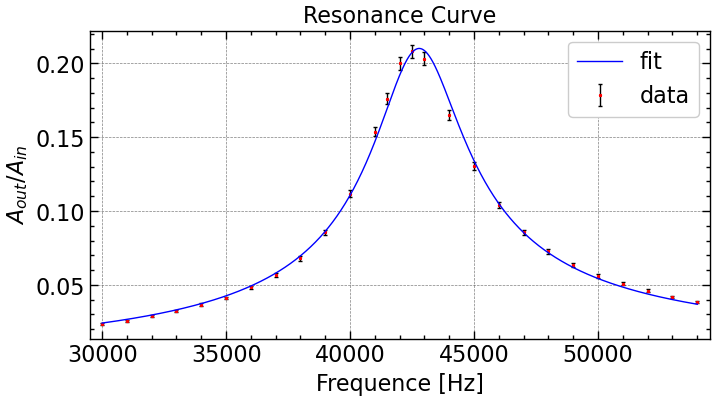

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4)) 

ax.errorbar(f, a, yerr=sig_a, fmt = 'r*', markersize=2., ecolor='k', elinewidth=1., capsize=1.5, label='data', zorder=1)
_pts = np.linspace(f[0], f[-1], 1000)
ax.plot(_pts, res(_pts, amp_fit, omega_fit, delta_fit), label='fit', color='b', linewidth=1., zorder=2)
ax.set_title('Resonance Curve')
ax.set_xlabel('Frequence [Hz]')
ax.set_ylabel('$A_{out} / A_{in}$')
ax.set_xlim((29500, 54500))
ax.legend()
fig.savefig('images/fit_resonance.png', dpi=100);

**Residuals of the resonance curve**

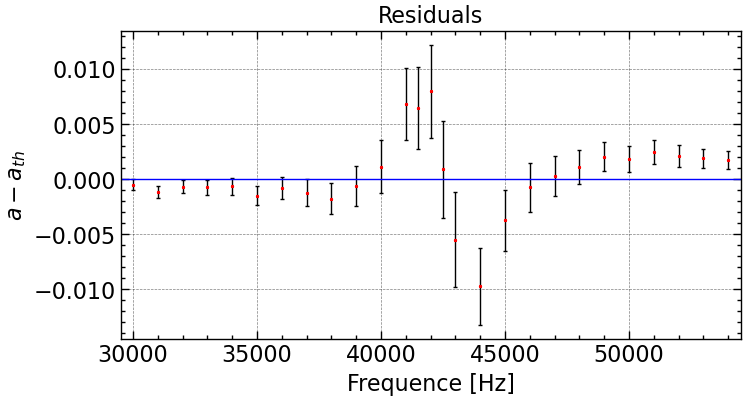

In [25]:
res = np.array(a - res(f, amp_fit, omega_fit, delta_fit))
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4)) 

ax.errorbar(f, res, yerr=sig_a, fmt='r*', markersize=2., ecolor='k', elinewidth=1., capsize=1.5)
ax.set_title('Residuals')
ax.set_xlabel('Frequence [Hz]')
ax.set_ylabel('$a - a_{th}$')
ax.set_xlim((29500, 54500))
ax.axhline(y=0.0, color='b', linestyle='-', linewidth=1.)
fig.savefig('images/residuals_resonance.png', dpi=100);

**Non-linear fit of the phase curve with Minuit**

In [26]:
# chi-square function to minimise
def chi_square_ph(R, L, C):
    return sum((ph - fitphase(R, L, C))**2 / (sig_ph**2))

chi_square_ph.errordef = Minuit.LEAST_SQUARES
# initial guesses
m_ph = Minuit(chi_square_ph, R=50, L=2.2E-3, C=6.4E-9)
m_ph.migrad()
# best-fit estimates and their errors
R_fit = m_ph.values['R']
L_fit = m_ph.values['L'] 
C_fit = m_ph.values['C']
err_ph = [np.sqrt(m_ph.covariance[0,0]), np.sqrt(m_ph.covariance[1,1]), np.sqrt(m_ph.covariance[2,2])]
print(f"R: {R_fit:.2f} +/- {err_ph[0]:.2f}")
print(f"L: {L_fit:.1e} +/- {err_ph[1]:.1e}")
print(f"C: {C_fit:.1e} +/- {err_ph[2]:.1e}")

R: 46.10 +/- 1.54
L: 2.2e-03 +/- 5.0e-05
C: 6.4e-09 +/- 1.5e-10


**Plot of the phase curve**

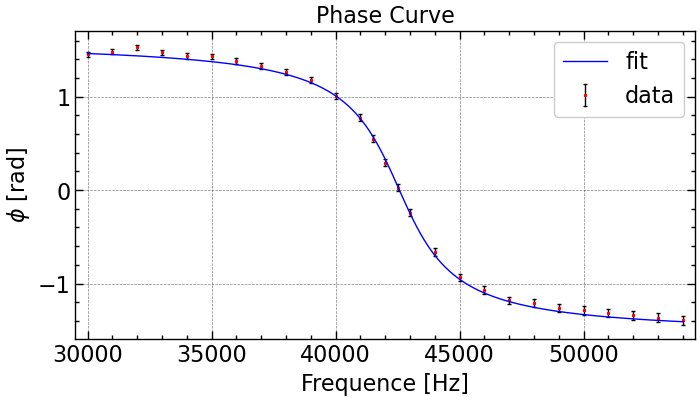

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4)) 

ax.errorbar(f, ph, yerr=sig_ph, fmt='r*', markersize=2., ecolor='k', elinewidth=1., capsize=1.5, label='data', zorder=1)
_pts = np.linspace(f[0], f[-1], 1000)
ax.plot(_pts, phase(_pts, R_fit, L_fit, C_fit), label='fit', color='b', linewidth=1., zorder=2)
ax.set_title('Phase Curve')
ax.set_xlabel('Frequence [Hz]')
ax.set_ylabel('$\phi$ [rad]')
ax.set_xlim((29500, 54500))
ax.legend()
fig.savefig('images/fit_phase.png', dpi=100);

**Residuals of the phase curve**

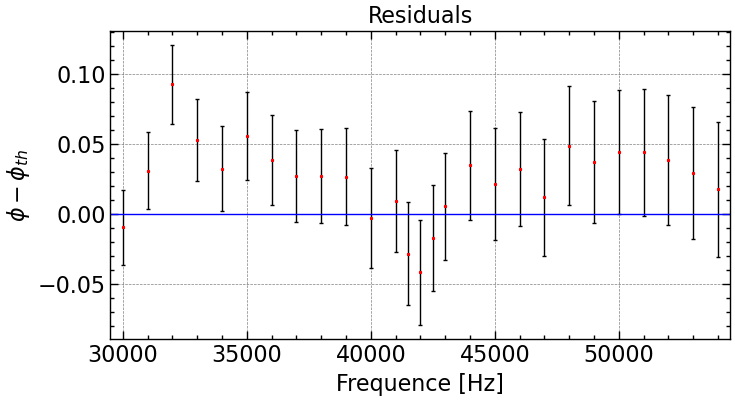

In [28]:
res = np.array(ph - phase(f, R_fit, L_fit, C_fit))
  
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4)) 

ax.errorbar(f, res, yerr=sig_ph, fmt='r*', markersize=2., ecolor='k', elinewidth=1., capsize=1.5)
ax.set_title('Residuals')
ax.set_xlabel('Frequence [Hz]')
ax.set_ylabel('$\phi - \phi_{th}$')
ax.set_xlim((29500, 54500))
ax.axhline(y=0.0, color='b', linestyle='-', linewidth=1.)
fig.savefig('images/residuals_phase.png', dpi=100);

**$\chi^2$ profiling**

In [29]:
'''
test vectors in a neighbourhood of the best-fit estimates.
size heavily limited by computational complexity.
'''
amp_test = amp_fit + np.linspace(-0.02*amp_fit, 0.02*amp_fit, 500)
omega_test = omega_fit + np.linspace(-0.002*omega_fit, 0.002*omega_fit, 500)
delta_test = delta_fit + np.linspace(-0.05*delta_fit, 0.05*delta_fit, 500)

chi_sq = np.zeros((len(omega_test), len(delta_test), len(amp_test)))
chi_sq_minA = np.zeros((len(omega_test), len(delta_test)))
chi_sq_minO = np.zeros((len(amp_test), len(delta_test)))
chi_sq_minD = np.zeros((len(amp_test), len(omega_test)))

''' 
more efficient way
x, y, z = np.meshgrid(amp_test, omega_test, delta_test, indexing='ij')
chi_sq = np.vectorize(chi_square)(x, y, z).T
chi_sq_minA = np.minimum.reduce(chi_sq, axis=0)
chi_sq_minO = np.minimum.reduce(chi_sq, axis=1)
chi_sq_minD = np.minimum.reduce(chi_sq, axis=2)
'''

# filling chi_sq
for i in range(len(amp_test)):
    for j in range(len(omega_test)):
        for k in range(len(delta_test)):
            chi_sq[i, j, k] = chi_square(amp_test[i], omega_test[j], delta_test[k])

# profiling on A
for i in range(len(omega_test)):
    for j in range(len(delta_test)):
        chi_sq_minA[i, j] = min(chi_sq[:, i, j])

# profiling on Omega
for i in range(len(amp_test)):
    for j in range(len(delta_test)):
        chi_sq_minO[i, j] = min(chi_sq[i, :, j])

# profiling on delta
for i in range(len(amp_test)):
    for j in range(len(omega_test)):
        chi_sq_minD[i, j] = min(chi_sq[i, j, :])

**$\chi^2$ contour plots**

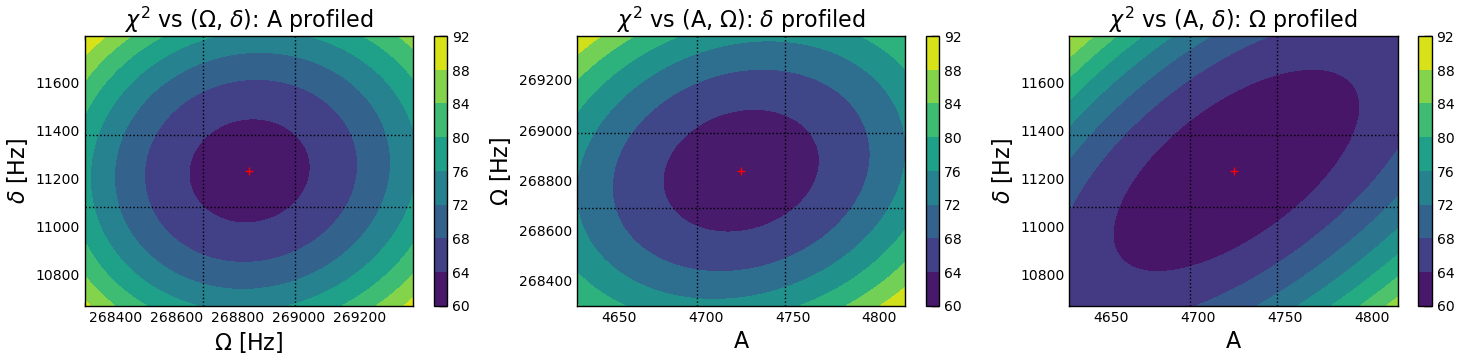

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 3.5))

ax = axes[0]
im = ax.contourf(omega_test, delta_test, chi_sq_minA)
ax.plot(omega_fit, delta_fit, 'r+') 
ax.set_title('$\chi^2$ vs ($\Omega$, $\delta$): A profiled')
ax.set_xlabel('$\Omega$ [Hz]')
ax.set_ylabel('$\delta$ [Hz]')
ax.axvline(x=omega_fit-err[1], lw=1, ls=':', color='k')
ax.axvline(x=omega_fit+err[1], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit-err[2], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit+err[2], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=10) 

ax = axes[1]
ax.contourf(amp_test, omega_test, chi_sq_minD)
ax.plot(amp_fit, omega_fit, 'r+')
ax.set_title('$\chi^2$ vs (A, $\Omega$): $\delta$ profiled')
ax.set_xlabel('A')
ax.set_ylabel('$\Omega$ [Hz]')
ax.axvline(x=amp_fit-err[0], lw=1, ls=':', color='k')
ax.axvline(x=amp_fit+err[0], lw=1, ls=':', color='k')
ax.axhline(y=omega_fit-err[1], lw=1, ls=':', color='k')
ax.axhline(y=omega_fit+err[1], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=10) 

ax = axes[2]
ax.contourf(amp_test, delta_test, chi_sq_minO)
ax.plot(amp_fit, delta_fit, 'r+')
ax.set_title('$\chi^2$ vs (A, $\delta$): $\Omega$ profiled')
ax.set_xlabel('A')
ax.set_ylabel('$\delta$ [Hz]')
ax.axvline(x=amp_fit-err[0], lw=1, ls=':', color='k')
ax.axvline(x=amp_fit+err[0], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit-err[2], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit+err[2], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=10) 

fig.savefig('images/contour.png', dpi=100);

**$\chi^2$ confidence ellipses**\
The dashed lines identify the errors returned by Minuit.\
They should frame perfectly the confidence ellipses given by $\chi^2 - \chi^2_{min} = 1$.

In [31]:
chi_sq_min = chi_square(amp_fit, omega_fit, delta_fit)

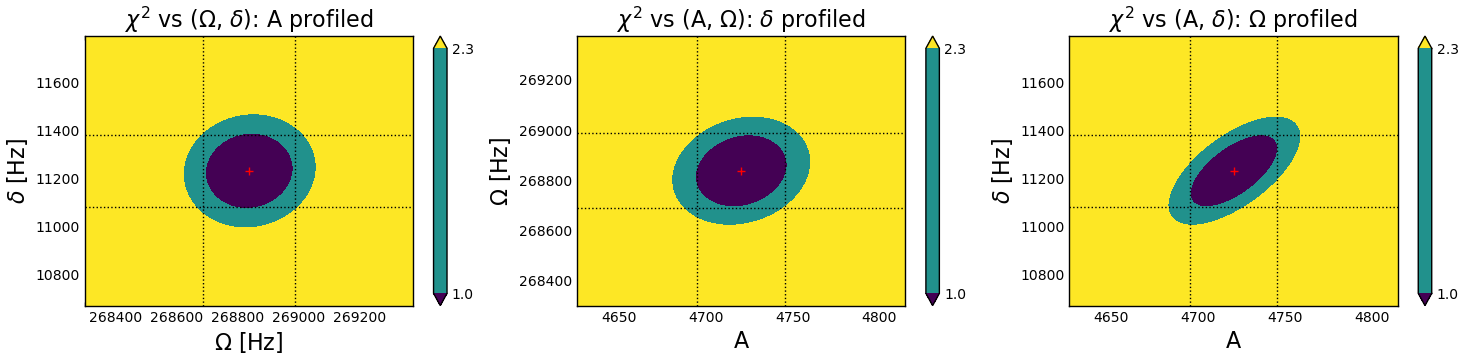

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 3.5))

ax = axes[0]
im = ax.contourf(omega_test, delta_test, chi_sq_minA - chi_sq_min, levels=[1, 2.3], extend='both')
ax.plot(omega_fit, delta_fit, 'r+')
ax.set_title('$\chi^2$ vs ($\Omega$, $\delta$): A profiled')
ax.set_xlabel('$\Omega$ [Hz]')
ax.set_ylabel('$\delta$ [Hz]')
ax.axvline(x=omega_fit-err[1], lw=1, ls=':', color='k')
ax.axvline(x=omega_fit+err[1], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit-err[2], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit+err[2], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=10)

ax = axes[1]
ax.contourf(amp_test, omega_test, chi_sq_minD - chi_sq_min, levels=[1, 2.3], extend='both')
ax.plot(amp_fit, omega_fit, 'r+')
ax.set_title('$\chi^2$ vs (A, $\Omega$): $\delta$ profiled')
ax.set_xlabel('A')
ax.set_ylabel('$\Omega$ [Hz]')
ax.axvline(x=amp_fit-err[0], lw=1, ls=':', color='k')
ax.axvline(x=amp_fit+err[0], lw=1, ls=':', color='k')
ax.axhline(y=omega_fit-err[1], lw=1, ls=':', color='k')
ax.axhline(y=omega_fit+err[1], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=10)

ax = axes[2]
ax.contourf(amp_test, delta_test, chi_sq_minO - chi_sq_min, levels=[1, 2.3], extend='both')
ax.plot(amp_fit, delta_fit, 'r+')
ax.set_title('$\chi^2$ vs (A, $\delta$): $\Omega$ profiled')
ax.set_xlabel('A')
ax.set_ylabel('$\delta$ [Hz]')
ax.axvline(x=amp_fit-err[0], lw=1, ls=':', color='k')
ax.axvline(x=amp_fit+err[0], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit-err[2], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit+err[2], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=10)

fig.savefig('images/profiling.png', dpi=100);

**Conversion to a probability map**\
Remember: for 2 degrees of freedom the $\chi^2$ distribution is just an exponential.

In [33]:
# exponential + normalisation so that the total sum is 1
normA = np.exp(-0.5*(chi_sq_minA - chi_sq_min)) / np.sum(np.exp(-0.5*(chi_sq_minA - chi_sq_min)))
normD = np.exp(-0.5*(chi_sq_minD - chi_sq_min)) / np.sum(np.exp(-0.5*(chi_sq_minD - chi_sq_min)))
normO = np.exp(-0.5*(chi_sq_minO - chi_sq_min)) / np.sum(np.exp(-0.5*(chi_sq_minO - chi_sq_min)))

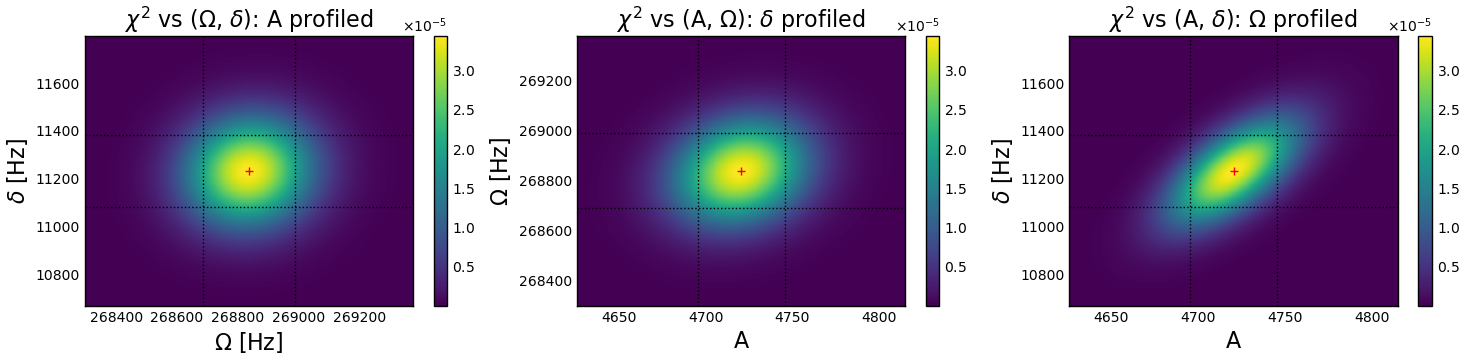

In [34]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

fig, axes = plt.subplots(1, 3, figsize=(18, 3.5))

ax = axes[0]
im = ax.pcolor(omega_test, delta_test, normA, shading='auto')
ax.plot(omega_fit, delta_fit, 'r+')
ax.set_title('$\chi^2$ vs ($\Omega$, $\delta$): A profiled')
ax.set_xlabel('$\Omega$ [Hz]')
ax.set_ylabel('$\delta$ [Hz]')
ax.axvline(x=omega_fit-err[1], lw=1, ls=':', color='k')
ax.axvline(x=omega_fit+err[1], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit-err[2], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit+err[2], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax, format=formatter)
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.get_offset_text().set(size=10)

ax = axes[1]
ax.pcolor(amp_test, omega_test, normD, shading='auto')
ax.plot(amp_fit, omega_fit, 'r+')
ax.set_title('$\chi^2$ vs (A, $\Omega$): $\delta$ profiled')
ax.set_xlabel('A')
ax.set_ylabel('$\Omega$ [Hz]')
ax.axvline(x=amp_fit-err[0], lw=1, ls=':', color='k')
ax.axvline(x=amp_fit+err[0], lw=1, ls=':', color='k')
ax.axhline(y=omega_fit-err[1], lw=1, ls=':', color='k')
ax.axhline(y=omega_fit+err[1], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax, format=formatter)
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.get_offset_text().set(size=10)

ax = axes[2]
ax.pcolor(amp_test, delta_test, normO, shading='auto')
ax.plot(amp_fit, delta_fit, 'r+')
ax.set_title('$\chi^2$ vs (A, $\delta$): $\Omega$ profiled')
ax.set_xlabel('A')
ax.set_ylabel('$\delta$ [Hz]')
ax.axvline(x=amp_fit-err[0], lw=1, ls=':', color='k')
ax.axvline(x=amp_fit+err[0], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit-err[2], lw=1, ls=':', color='k')
ax.axhline(y=delta_fit+err[2], lw=1, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)
cbar = fig.colorbar(im, ax=ax, format=formatter)
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.get_offset_text().set(size=10)

fig.savefig('images/probability.png', dpi=100);

**Area inside confidence ellipse**\
Computation of the area inside the region given by $\chi^2 - \chi^2_{min} = 2.3$ for each profilation.\
By the properties of the $\chi^2$ c.d.f., this should be around 68.3%.

In [35]:
sumA = 0
for i in range(len(omega_test)):
    for j in range(len(delta_test)):
        if (chi_sq_minA[i, j] - chi_sq_min < 2.3):
            sumA += normA[i, j]
sumD = 0
for i in range(len(amp_test)):
    for j in range(len(delta_test)):
        if (chi_sq_minD[i, j] - chi_sq_min < 2.3):
            sumD += normD[i, j]
sumO = 0
for i in range(len(amp_test)):
    for j in range(len(omega_test)):
        if (chi_sq_minO[i, j] - chi_sq_min < 2.3):
            sumO += normO[i, j]

print(f"Area for A profiled: {sumA * 100:.2f}%")
print(f"Area for omega profiled: {sumO * 100:.2f}%")
print(f"Area for delta profiled: {sumD * 100:.2f}%") 

Area for A profiled: 68.36%
Area for omega profiled: 68.37%
Area for delta profiled: 68.37%


**Marginalized p.d.f.**

In [36]:
# A profiled
y1 = np.sum(normA, axis=0)
y2 = np.sum(normA, axis=1)
# delta profiled
y3 = np.sum(normD, axis=0)
y4 = np.sum(normD, axis=1)
# omega profiled
y5 = np.sum(normO, axis=0)
y6 = np.sum(normO, axis=1)

In [37]:
prob1 = prob2 = prob3 = prob4 = prob5 = prob6 = 0
# compute areas under the distributions between -1 and +1 standard errors
for i in range(len(omega_test)):
    if (omega_test[i] > omega_fit-err[1]) and (omega_test[i] < omega_fit+err[1]):
        prob1 += y1[i]
for i in range(len(delta_test)):
    if (delta_test[i] > delta_fit-err[2]) and (delta_test[i] < delta_fit+err[2]):
        prob2 += y2[i] 
for i in range(len(amp_test)):
    if (amp_test[i] > amp_fit-err[0]) and (amp_test[i] < amp_fit+err[0]):
        prob3 += y3[i] 
for i in range(len(omega_test)):
    if (omega_test[i] > omega_fit-err[1]) and (omega_test[i] < omega_fit+err[1]):
        prob4 += y4[i]
for i in range(len(amp_test)):
    if (amp_test[i] > amp_fit-err[0]) and (amp_test[i] < amp_fit+err[0]):
        prob5 += y5[i] 
for i in range(len(delta_test)):
    if (delta_test[i] > delta_fit-err[2]) and (delta_test[i] < delta_fit+err[2]):
        prob6 += y6[i] 

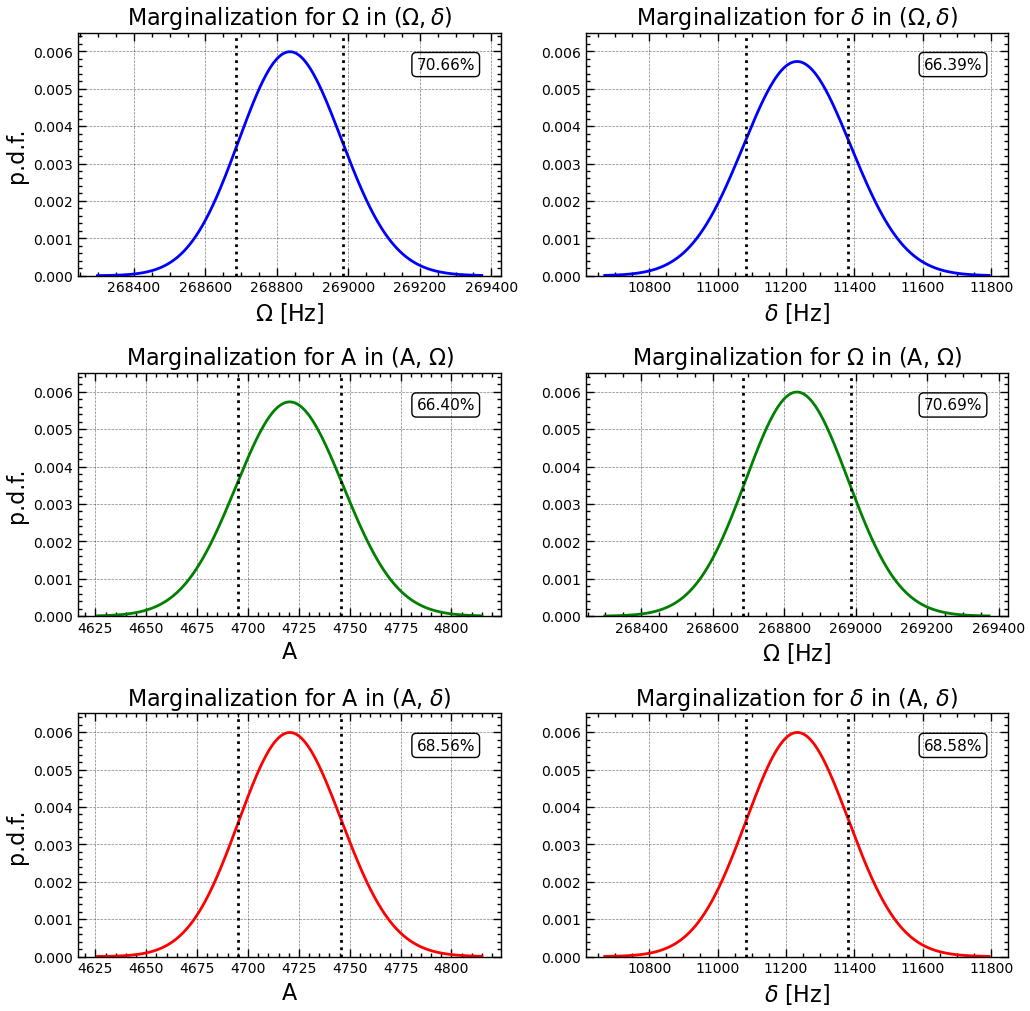

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

ax = axes[0, 0]
ax.plot(omega_test, y1, 'b-')
ax.set_ylim([0.000, 0.0065])
ax.set_title('Marginalization for $\Omega$ in ($\Omega, \delta$)')
ax.set_xlabel('$\Omega$ [Hz]')
ax.set_ylabel('p.d.f.')
ax.text(0.8, 0.85, f"{prob1 * 100:.2f}%", transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
ax.axvline(x=omega_fit-err[1], lw=2, ls=':', color='k')
ax.axvline(x=omega_fit+err[1], lw=2, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)

ax = axes[0, 1]
ax.plot(delta_test, y2, 'b-')
ax.set_ylim([0.000, 0.0065])
ax.set_title('Marginalization for $\delta$ in ($\Omega, \delta$)')
ax.set_xlabel('$\delta$ [Hz]')
ax.text(0.8, 0.85, f"{prob2 * 100:.2f}%", transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
ax.axvline(x=delta_fit-err[2], lw=2, ls=':', color='k')
ax.axvline(x=delta_fit+err[2], lw=2, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)

ax = axes[1, 0]
ax.plot(amp_test, y3, 'g-')
ax.set_ylim([0.000, 0.0065])
ax.set_title('Marginalization for A in (A, $\Omega$)')
ax.set_xlabel('A')
ax.set_ylabel('p.d.f.')
ax.text(0.8, 0.85, f"{prob3 * 100:.2f}%", transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
ax.axvline(x=amp_fit-err[0], lw=2, ls=':', color='k')
ax.axvline(x=amp_fit+err[0], lw=2, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)

ax = axes[1, 1]
ax.plot(omega_test, y4, 'g-')
ax.set_ylim([0.000, 0.0065])
ax.set_title('Marginalization for $\Omega$ in (A, $\Omega$)')
ax.set_xlabel('$\Omega$ [Hz]')
ax.text(0.8, 0.85, f"{prob4 * 100:.2f}%", transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
ax.axvline(x=omega_fit-err[1], lw=2, ls=':', color='k')
ax.axvline(x=omega_fit+err[1], lw=2, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)

ax = axes[2, 0]
ax.plot(amp_test, y5, 'r-')
ax.set_ylim([0.000, 0.0065])
ax.set_title('Marginalization for A in (A, $\delta$)')
ax.set_xlabel('A')
ax.set_ylabel('p.d.f.')
ax.text(0.8, 0.85, f"{prob5 * 100:.2f}%", transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
ax.axvline(x=amp_fit-err[0], lw=2, ls=':', color='k')
ax.axvline(x=amp_fit+err[0], lw=2, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)

ax = axes[2, 1]
ax.plot(delta_test, y6, 'r-')
ax.set_ylim([0.000, 0.0065])
ax.set_title('Marginalization for $\delta$ in (A, $\delta$)')
ax.set_xlabel('$\delta$ [Hz]')
ax.text(0.8, 0.85, f"{prob6 * 100:.2f}%", transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
ax.axvline(x=delta_fit-err[2], lw=2, ls=':', color='k')
ax.axvline(x=delta_fit+err[2], lw=2, ls=':', color='k')
ax.tick_params(axis='both', which='major', labelsize=10)

fig.subplots_adjust(hspace=0.4)
fig.savefig('images/marginalization.png', dpi=100);

**Simulation of 10000 toy datasets**

In [39]:
'''
10000 values normally distributed around the datapoint with variance equal to the variance of the datapoint are generated
for every datapoint in the original dataset.
'''
a_toy = np.zeros((len(a), 10000))
for i in range(len(a)):
    a_toy[i] = sig_a[i] * np.random.randn(10000) + a[i]

In [41]:
amp_toy = np.zeros(10000)
omega_toy = np.zeros(10000)
delta_toy = np.zeros(10000)

# for each toy dataset the best-fit estimates are computed by least squares
for j in range(10000):
    def chi_square_toy(amp, omega, delta):
        return sum((a_toy[:, j] - fitres(amp, omega, delta))**2 / (sig_a**2))
    chi_square_toy.errordef = Minuit.LEAST_SQUARES
    # initial guesses
    m = Minuit(chi_square_toy, amp=5000, omega=267000, delta=10000) 
    m.migrad()
    # best-fit estimates
    amp_toy[j] = m.values['amp']
    omega_toy[j] = m.values['omega'] 
    delta_toy[j] = m.values['delta']

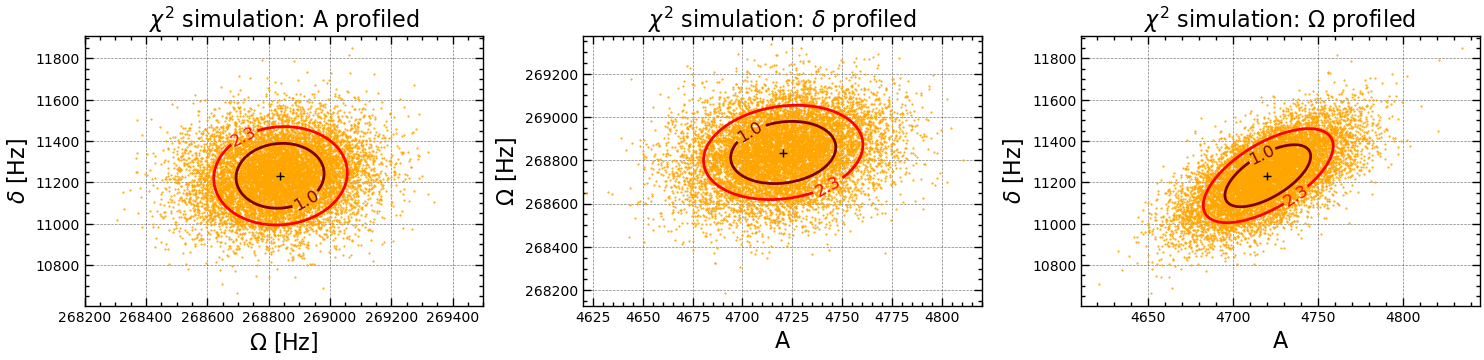

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 3.5))

ax = axes[0]
im = ax.contour(omega_test, delta_test, chi_sq_minA - chi_sq_min, [1, 2.3], colors=['maroon', 'red'], linewidths=2)
ax.clabel(im, inline=True, fontsize=12)
ax.plot(omega_fit, delta_fit, 'k+')
ax.set_title('$\chi^2$ simulation: A profiled')
ax.set_xlabel('$\Omega$ [Hz]')
ax.set_ylabel('$\delta$ [Hz]')
ax.set_xlim([268200, 269500])
ax.scatter(omega_toy, delta_toy, s=0.3, c='orange')
ax.tick_params(axis='both', which='major', labelsize=10)

ax = axes[1]
im = ax.contour(amp_test, omega_test, chi_sq_minD - chi_sq_min, [1, 2.3], colors=['maroon', 'red'], linewidths=2)
ax.clabel(im, inline=True, fontsize=12)
ax.plot(amp_fit, omega_fit, 'k+')
ax.set_title('$\chi^2$ simulation: $\delta$ profiled')
ax.set_xlabel('A')
ax.set_ylabel('$\Omega$ [Hz]')
ax.set_xlim([4620, 4820])
ax.scatter(amp_toy, omega_toy, s=0.3, c='orange')
ax.tick_params(axis='both', which='major', labelsize=10)

ax = axes[2]
im = ax.contour(amp_test, delta_test, chi_sq_minO - chi_sq_min, [1, 2.3], colors=['maroon', 'red'], linewidths=2)
ax.clabel(im, inline=True, fontsize=12)
ax.plot(amp_fit, delta_fit, 'k+')
ax.set_title('$\chi^2$ simulation: $\Omega$ profiled')
ax.set_xlabel('A')
ax.set_ylabel('$\delta$ [Hz]')
ax.scatter(amp_toy, delta_toy, s=0.3, c='orange')
ax.tick_params(axis='both', which='major', labelsize=10)

fig.subplots_adjust(wspace=0.25)
fig.savefig('images/simulation.png', dpi=100);